**ENHANCING**

**Generating a pandas dataframe from the source .pkl file**

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

# Set options to show all columns
pd.set_option('display.max_columns', None)

# Load .pkl file and generate pandas dataframe
input_pkl = r'..\data\clean\after_step_1_cleaning_houses.pkl' # Fill your path to file
df_1 = pd.read_pickle(input_pkl)

df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5924 entries, 0 to 9994
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  5924 non-null   Int64   
 1   locality_name       5924 non-null   category
 2   Postal_code         5924 non-null   category
 3   Price               5924 non-null   Int64   
 4   Subtype             5924 non-null   object  
 5   Number_of_bedrooms  5924 non-null   Int64   
 6   Living_area         5924 non-null   Int64   
 7   street              5924 non-null   category
 8   number              5906 non-null   category
 9   latitude            5921 non-null   float64 
 10  longitude           5921 non-null   float64 
 11  Open_fire           5924 non-null   bool    
 12  Swimming_Pool       5924 non-null   bool    
 13  hasTerrace          4016 non-null   object  
 14  terraceSurface      5924 non-null   Int64   
 15  gardenSurface       5924 non-null   Int64  

**Adding columns on price per m^2**
- And display of the info of the dataframe at start of analysis

In [13]:
# Adding new column of price per m2 net habitable surface with safeguard for ZeroDivisionError
df_1['price_per_sqm'] = np.where(df_1['Living_area'] == 0, np.nan, df_1['Price'] / df_1['Living_area'])

# Adding new column of price per m2 land surface with safeguard for ZeroDivisionError
df_1['price_per_sqm_land'] = np.where(df_1['landSurface'] == 0, np.nan, df_1['Price'] / df_1['landSurface'])

# Display info on the dataframe
df_1.info()
df_1_shape = df_1.shape


<class 'pandas.core.frame.DataFrame'>
Index: 5924 entries, 0 to 9994
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  5924 non-null   Int64   
 1   locality_name       5924 non-null   category
 2   Postal_code         5924 non-null   category
 3   Price               5924 non-null   Int64   
 4   Subtype             5924 non-null   object  
 5   Number_of_bedrooms  5924 non-null   Int64   
 6   Living_area         5924 non-null   Int64   
 7   street              5924 non-null   category
 8   number              5906 non-null   category
 9   latitude            5921 non-null   float64 
 10  longitude           5921 non-null   float64 
 11  Open_fire           5924 non-null   bool    
 12  Swimming_Pool       5924 non-null   bool    
 13  hasTerrace          4016 non-null   object  
 14  terraceSurface      5924 non-null   Int64   
 15  gardenSurface       5924 non-null   Int64  

**Categorical Data**

In [14]:
# Getting an idea of the values in columns with dtype 'category'

for col in df_1.select_dtypes(include=['category']).columns:
    print(f"Counts for {col}:")
    print(df_1[col].value_counts())
    unique_count = df_1[col].nunique()
    print("\n")
    print(f"Number of unique entries in {col}: {unique_count}\n")

Counts for locality_name:
locality_name
Gent                 201
Antwerpen            115
Aalst                 77
Ronse                 73
Brugge                72
                    ... 
Beauraing Honnay       0
Appelterre-Eichem      0
Arlon (Bonnert)        0
Arlon (Stockem)        0
Asse Zellik            0
Name: count, Length: 1279, dtype: int64


Number of unique entries in locality_name: 1138

Counts for Postal_code:
Postal_code
9000    162
8300     80
9600     73
9300     69
8800     69
       ... 
8554      0
9681      0
9667      0
1332      0
1331      0
Name: count, Length: 793, dtype: int64


Number of unique entries in Postal_code: 740

Counts for street:
street
Stationsstraat        37
Molenstraat           33
Kerkstraat            28
Veldstraat            18
Nieuwstraat           17
                      ..
Rue Victor Lefèvre     0
Rue Saint Léonard      0
Rue Saint-Lambert      0
Rue Saint-Laurent      0
Rue Saint-Nicolas      0
Name: count, Length: 5284, dtype: int6

In [15]:
# Copy dataframe contents to a new dataframe
df_2 = df_1.copy()

# Converting the postal codes to dtype 'str'
df_2['Postal_code'] = df_2['Postal_code'].astype(str)

# Check the missing values
df_2['Postal_code'].isnull().mean()*100

# Assess the number of unique postal codes
df_2['Postal_code'].value_counts().nunique()

52

*Postal code - bar graph of top 20*

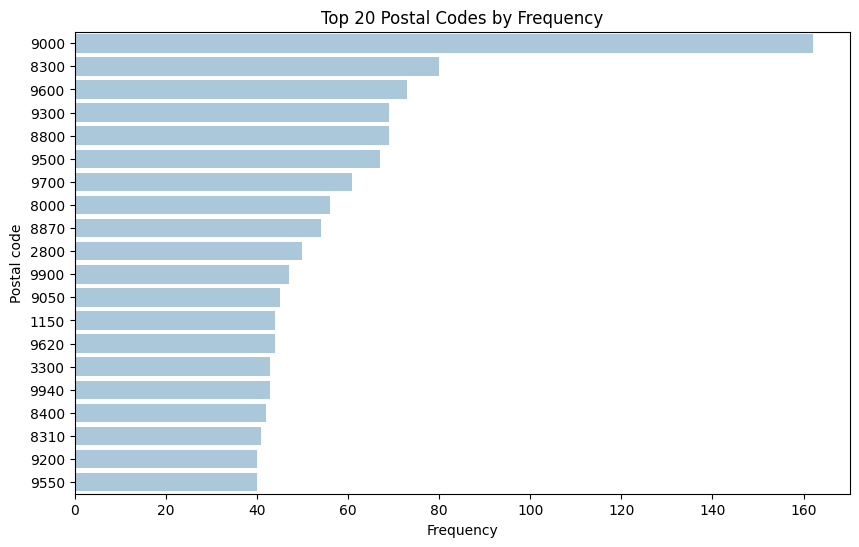

In [16]:
# Checking the postal codes and their counts
frequency = df_2['Postal_code'].value_counts()

# Showing the top 20 
top_n = 20 

# Plotting only the top N categories
top_n_categories = frequency.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_n_categories.values, y=top_n_categories.index, color='#A3C9E2')
plt.title(f'Top {top_n} Postal Codes by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Postal code')
plt.show()

*Province - mapping city to a province*

In [17]:
# Copy dataframe contents to a new dataframe
df_3 = df_2.copy()

# Creating the column province

def get_province(postal_code):
    if postal_code.startswith('1'):
        return 'Brussels' if int(postal_code) < 1300 else 'Brabant_Wallon'
    elif postal_code.startswith('2'):
        return 'Antwerp'
    elif postal_code.startswith('4'):
        return 'Liège'
    elif postal_code.startswith('5'):
        return 'Namur'
    elif postal_code.startswith('6'):
        return 'Luxembourg'
    elif postal_code.startswith('7'):
        return 'Hainaut'
    elif postal_code.startswith('8'):
        return 'West Flanders'
    elif postal_code.startswith('9'):
        return 'East Flanders'
    elif postal_code.startswith('3'):
        return 'Flemish Brabant' if int(postal_code) < 3500 else 'Limburg'
    else:
        return None 

df_3['Province'] = df_3['Postal_code'].apply(get_province).copy()

# Assigning the dtypes
df_3['Province'] = df_3['Province'].astype('category')

*Province - bar graph of properties per province*

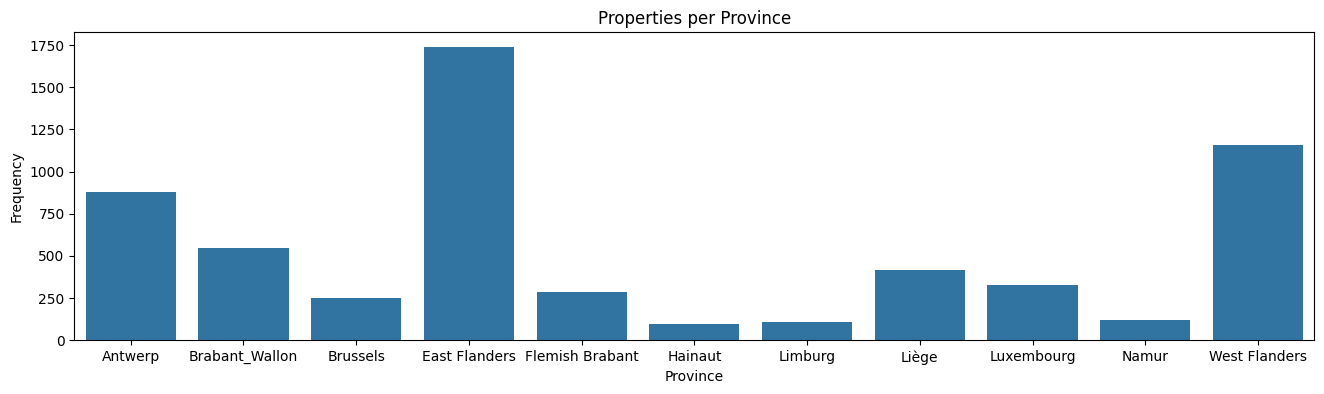

In [18]:
# Checking the amount of properties per province
frequency = df_3['Province'].value_counts()

# Plotting the frequency
plt.figure(figsize=(16, 4))
sns.barplot(x=frequency.index, y=frequency.values)
plt.title('Properties per Province')
plt.xlabel('Province')
plt.ylabel('Frequency')
plt.show()

*Proximity of city - generating the data column*

In [19]:
# Creating a column for proximity to the 10 main Belgian cities:
cities_data = {'City': ['Brussels', 'Antwerp', 'Ghent', 'Bruges', 'Liège','Namur', 'Leuven', 'Mons', 'Aalst', 'Sint-Niklaas'],
               'Latitude': [50.8503, 51.2211, 51.0543, 51.2093, 50.6050, 50.4674, 50.8798, 50.4542, 50.9403, 51.1449],
               'Longitude': [4.3517, 4.4120, 3.7174, 3.2240, 5.5797, 4.8712, 4.7033, 3.9514, 4.0364, 4.1525],
               'Radius': [10 for x in range(10)]}

cities_df = pd.DataFrame(cities_data)

cities_df.head(10)

# Make a geodataframe from the cities dataframe
cities_gdf = gpd.GeoDataFrame(cities_df,geometry=gpd.points_from_xy(cities_df.Longitude, cities_df.Latitude))

# Creating the buffer/radius zone (set on 10km)
cities_gdf['buffer'] = cities_gdf.geometry.buffer(cities_gdf['Radius'] / 111)
cities_gdf = cities_gdf.set_geometry('buffer')

cities_gdf.info()

# Checking and slicing original data and creating a new dataframe house_geo
house_geo= pd.DataFrame(df_3[['id', 'latitude', 'longitude']]).copy()
#house_geo.info()

# Making a geo dataframe from the dataframe
house_geo_gdf = gpd.GeoDataFrame(house_geo,geometry=gpd.points_from_xy(house_geo.longitude, house_geo.latitude))
#house_geo_gdf.info()

# Join the two gdf geodataframes 'house_geo_gdf' and 'cities_gdf'
joined_gdf = gpd.sjoin(house_geo_gdf, cities_gdf[['City', 'buffer']], how='left', predicate='intersects', lsuffix='_house', rsuffix='_city')
house_geo_gdf['Assigned_City'] = joined_gdf['City']
house_geo_gdf.info()

# Slicing and checking
check_city = house_geo_gdf[house_geo_gdf['Assigned_City'].notna()]
check_city.info()

# Merge the assigned city column to the main dataframe
df_3 = pd.merge(df_3, house_geo_gdf[['id', 'Assigned_City']], on='id', how='left')


#Make a boolean column of Assigned_City and transform to bool
df_3['Has_Assigned_City'] = df_3['Assigned_City'].notna()
df_3['Has_Assigned_City'] = df_3['Has_Assigned_City'].astype('bool')

df_3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   City       10 non-null     object  
 1   Latitude   10 non-null     float64 
 2   Longitude  10 non-null     float64 
 3   Radius     10 non-null     int64   
 4   geometry   10 non-null     geometry
 5   buffer     10 non-null     geometry
dtypes: float64(2), geometry(2), int64(1), object(1)
memory usage: 612.0+ bytes
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5924 entries, 0 to 9994
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             5924 non-null   Int64   
 1   latitude       5921 non-null   float64 
 2   longitude      5921 non-null   float64 
 3   geometry       5924 non-null   geometry
 4   Assigned_City  1671 non-null   object  
dtypes: Int64(1), float64(2), geometry(1), object(1)
memory

In [20]:
def assign_city_based_on_proximity_multiple_radii(df, cities_data, radius_list):
    
    """
    This function assigns cities to each row in the dataframe based on proximity 
    to the 10 main Belgian cities within multiple given distance radii.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing house data with 'latitude' and 'longitude' columns.
    cities_data (dict): Dictionary containing city data ('City', 'Latitude', 'Longitude').
    radius_list (list): List of radii (in kilometers) to consider for proximity.
    
    Returns:
    df (pd.DataFrame): Updated DataFrame with 'Assigned_City' columns and proximity-based boolean columns.
    """
    
   
    cities_df = pd.DataFrame(cities_data)
    cities_gdf = gpd.GeoDataFrame(cities_df, geometry=gpd.points_from_xy(cities_df.Longitude, cities_df.Latitude))
    
    cities_gdf = cities_gdf.set_geometry('geometry')
    
    house_geo = pd.DataFrame(df[['id', 'latitude', 'longitude']])
    house_geo_gdf = gpd.GeoDataFrame(house_geo, geometry=gpd.points_from_xy(house_geo.longitude, house_geo.latitude))

    house_geo_gdf = house_geo_gdf.set_geometry('geometry')
    
    for radius in radius_list:
        
        cities_gdf['buffer'] = cities_gdf.geometry.buffer(radius / 111)
        
        cities_gdf = cities_gdf.set_geometry('buffer')  
        
        
        joined_gdf = gpd.sjoin(house_geo_gdf, cities_gdf[['City', 'buffer']], how='left', predicate='intersects')
        joined_gdf = joined_gdf.drop_duplicates(subset='id')
        
        house_geo_gdf[f'Assigned_City_{radius}'] = joined_gdf['City']
        
        
        df = pd.merge(df, house_geo_gdf[['id', f'Assigned_City_{radius}']], on='id', how='left')
        
        
        df[f'Has_Assigned_City_{radius}'] = df[f'Assigned_City_{radius}'].notna()
        df[f'Has_Assigned_City_{radius}'] = df[f'Has_Assigned_City_{radius}'].astype('bool')
    
    return df

In [21]:
#Testing the function

cities_data = {
    'City': ['Brussels', 'Antwerp', 'Ghent', 'Bruges', 'Liège', 'Namur', 'Leuven', 'Mons', 'Aalst', 'Sint-Niklaas'],
    'Latitude': [50.8503, 51.2211, 51.0543, 51.2093, 50.6050, 50.4674, 50.8798, 50.4542, 50.9403, 51.1449],
    'Longitude': [4.3517, 4.4120, 3.7174, 3.2240, 5.5797, 4.8712, 4.7033, 3.9514, 4.0364, 4.1525]
}

radius_list = [5, 10, 15]

df_3 = assign_city_based_on_proximity_multiple_radii(df_3, cities_data, radius_list)

df_3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5924 entries, 0 to 5923
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    5924 non-null   Int64   
 1   locality_name         5924 non-null   category
 2   Postal_code           5924 non-null   object  
 3   Price                 5924 non-null   Int64   
 4   Subtype               5924 non-null   object  
 5   Number_of_bedrooms    5924 non-null   Int64   
 6   Living_area           5924 non-null   Int64   
 7   street                5924 non-null   category
 8   number                5906 non-null   category
 9   latitude              5921 non-null   float64 
 10  longitude             5921 non-null   float64 
 11  Open_fire             5924 non-null   bool    
 12  Swimming_Pool         5924 non-null   bool    
 13  hasTerrace            4016 non-null   object  
 14  terraceSurface        5924 non-null   Int64   
 15  gard

**Saving data to a new .csv file and a .pkl file**

In [22]:
# Save data to new csv file

output_csv = r'..\data\clean\after_step_2_enhancing.csv'  # Fill your path to file
df_3.to_csv(output_csv, index=False)


# Save data to new pkl file

import pickle
output_pkl = r'..\data\clean\after_step_2_enhancing.pkl' # Fill your path to file
with open(output_pkl, 'wb') as f:
    pickle.dump(df_3, f)
